In [16]:
description="""
Find the absorption fitting.
"""

In [17]:
import numpy as np
import scipy
from scipy import interpolate
from scipy import stats
from scipy.optimize import least_squares
import matplotlib.pyplot as pl
import statistics

%matplotlib inline

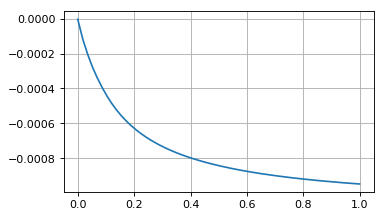

In [18]:
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model/1e6,fill_value="extrapolate")
    
    ynew = y(x)
    
    return a + (b * ynew)
    
a=0.0
b=1.0
x = np.arange(0,1,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.grid()
pl.show()

In [19]:
imc_pwr = np.loadtxt('20180910_ABS_IMC_pwr.dat')
dataITMX = np.loadtxt('20180910_ABS_ITMX_sph.dat')
dataITMY = np.loadtxt('20180910_ABS_ITMY_sph.dat')
dataETMX = np.loadtxt('20180910_ABS_ETMX_sph.dat')
dataETMY = np.loadtxt('20180910_ABS_ETMY_sph.dat')

In [42]:
#get power down time/index
indx = np.argwhere(imc_pwr<2.0)

s_indx = indx[0][0] + (16*30)#choose a start time a little bit after power down to get a quieter time after lockloss
e_indx = s_indx + 1*60*60*16  #convert index to seconds (1hour)

p_in=17.0
prc_g = 45.0
bs = 0.5
arm_g = 282.0

p_arm = p_in*prc_g*bs*arm_g

def get_abs(optic,opticname):
    time_ix = (optic[s_indx:e_indx,0] - optic[s_indx,0])/(60.0*60.0)
    data_ix = optic[s_indx:e_indx,1] - optic[s_indx,1]

    data_start_avg = np.average(data_ix[0:100])#rescale start to zero, guess
    data_ix = data_ix - data_start_avg

    [opt,b]=scipy.optimize.curve_fit(TL,time_ix,data_ix)
    arm_abs = 1e9*opt[1]/p_arm #scale to get the absorption in ppm
    print(arm_abs)

    
    ### Get the uncertainty
    m=100
    uns = e_indx+(60*16*40)
    un_arr = np.zeros(m)
    for i in range(m):
        i1 = int(uns+(float(i)*60*16))
        i2 = int(uns+(float(i+1)*60*16))
        t_un = optic[i1:i2,0]
        d_un = optic[i1:i2,1]
        [m_un,b_un] = scipy.optimize.curve_fit(TL,t_un,d_un)
        un_arr[i] = m_un[1]
    
    res = TL(time_ix,opt[0],opt[1])-data_ix
    rms = np.sqrt( np.sum(np.square(un_arr))/len(un_arr) )
    std = scipy.std(un_arr)
    sem = stats.sem(un_arr)
    print(1e9*rms/p_arm)
    print(1e9*std/p_arm)
    
    pl.figure(figsize=(10, 8), dpi=80)
    pl.subplot(211)
    pl.plot(time_ix,data_ix*1e6,label="Data")
    pl.plot(time_ix,res*1e6,label="Residuals")
    pl.plot(time_ix,TL(time_ix,opt[0],opt[1])*1e6,label="Comsol Model",linewidth=3.0)
    pl.ylabel("Spherical Power (uDiopters)")
    pl.xlabel("Time After Lockloss (Hours)")
    pl.legend()
    pl.title(opticname + " Abs Estimate = "+str(round(arm_abs,2))+"+/-"+str(round(1e9*rms/p_arm,2)) + "ppb")
    pl.grid()
    
    pl.subplot(212)
    pl.plot(optic[uns:int(uns+(m*60*15)),0],optic[uns:int(uns+(m*60*15)),1]*1e6, label="Data to estimate RMS Noise")
    pl.ylabel("Spherical Power (uDiopters)")
    pl.xlabel("Time (Sec) ")
    pl.grid()
    pl.legend()
    
    pl.savefig(str(opticname)+'.png')
    pl.show()

206.3288206944882


C:\Users\tvo88\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.785006667017169
1.78113379734292


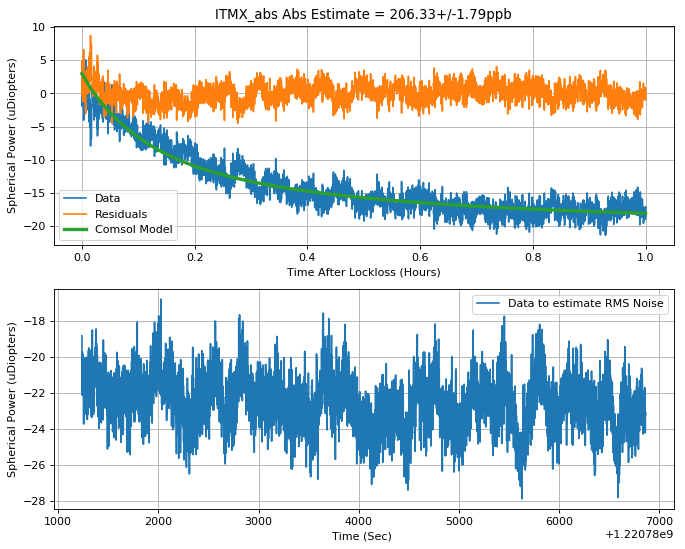

In [43]:
get_abs(dataITMX,"ITMX_abs")

454.1998420837987


C:\Users\tvo88\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.5186570654349676
1.5088409918664079


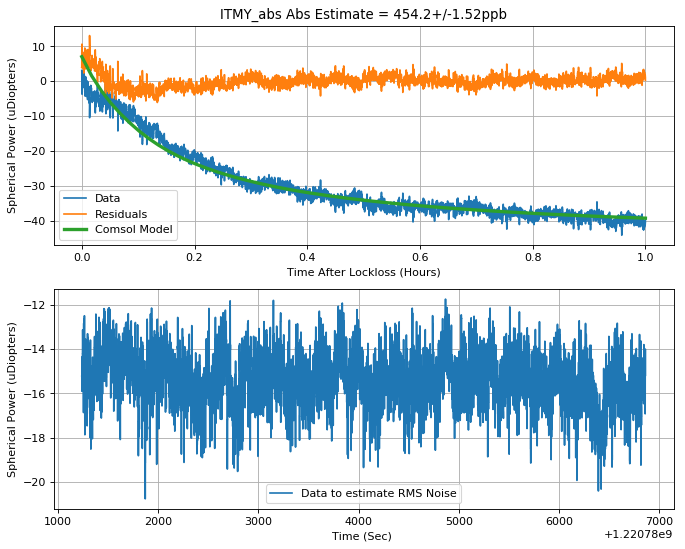

In [44]:
get_abs(dataITMY,"ITMY_abs")

155.25379001196995


C:\Users\tvo88\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


11.408130988303972
11.404824073324516


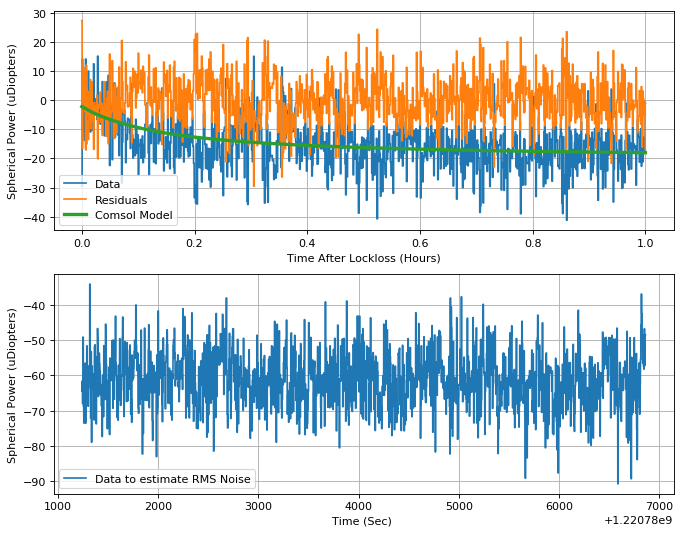

In [25]:
get_abs(dataETMX,"ETMX_abs")

119.25539700048986


C:\Users\tvo88\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


8.513643068539652
8.507016674585614


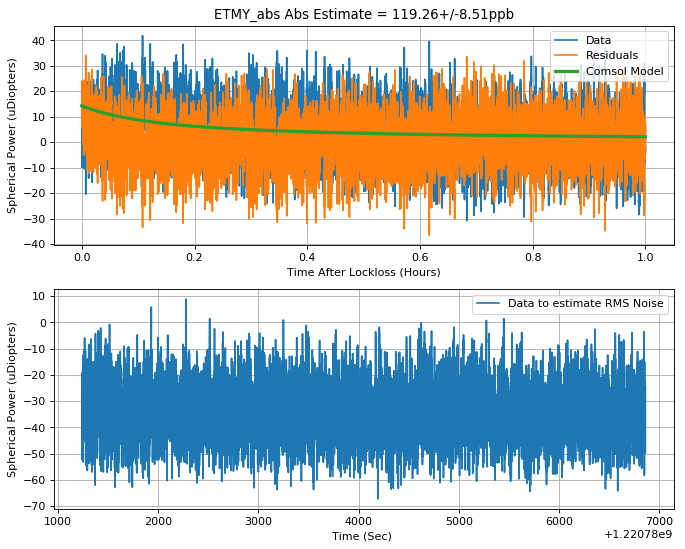

In [46]:
get_abs(dataETMY,"ETMY_abs")